Loading dataset...
shape (32561, 15)

Missing values per column:
age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64
       age workclass  fnlwgt     education  education-num  \
14      40   Private  121772     Assoc-voc             11   
27      54       NaN  180211  Some-college             10   
38      31   Private   84154  Some-college             10   
51      18   Private  226956       HS-grad              9   
61      32       NaN  293936       7th-8th              4   
...    ...       ...     ...           ...            ...   
32530   35       NaN  320084     Bachelors             13   
32531   30       NaN   33811     Bachelors             13   
32539   71       NaN  287372

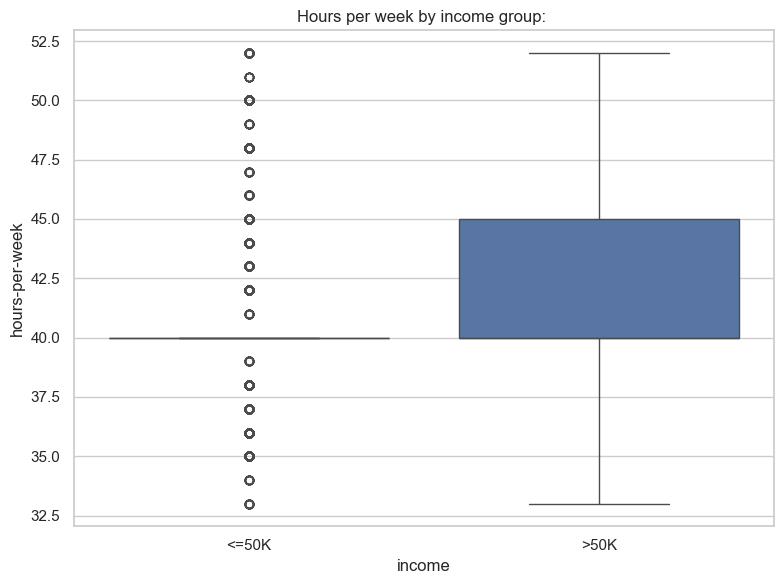

t-stat:   21.69685527792611 p-value:  3.095308850888037e-100
Numberic correlation with income: 
 income            1.000000
education-num     0.291560
age               0.234187
hours-per-week    0.172677
fnlwgt           -0.002178
capital-gain           NaN
capital-loss           NaN
Name: income, dtype: float64


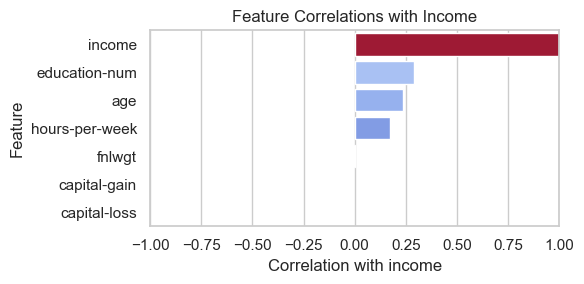

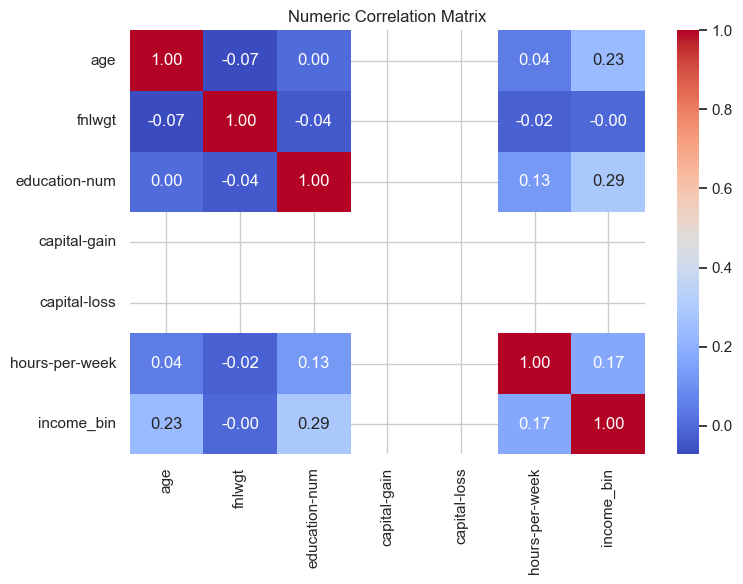

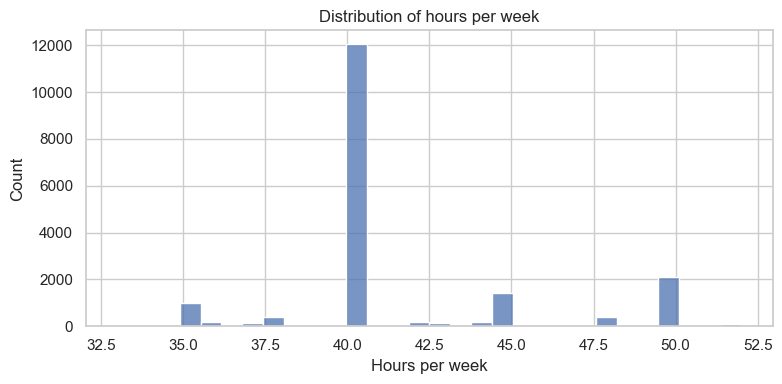

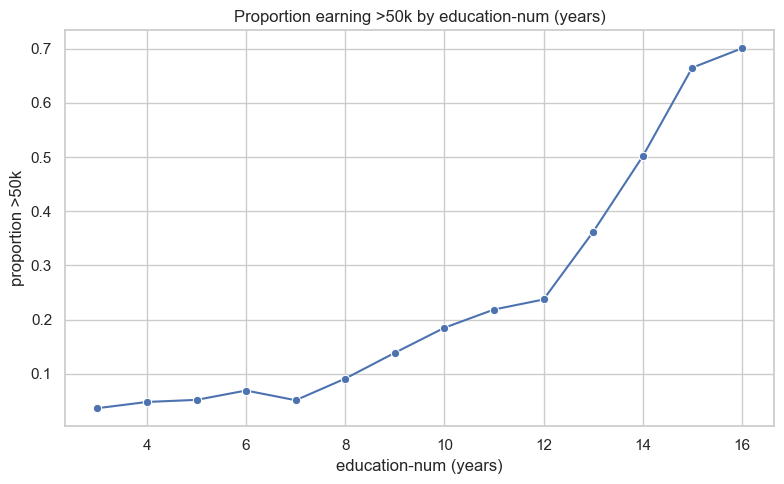

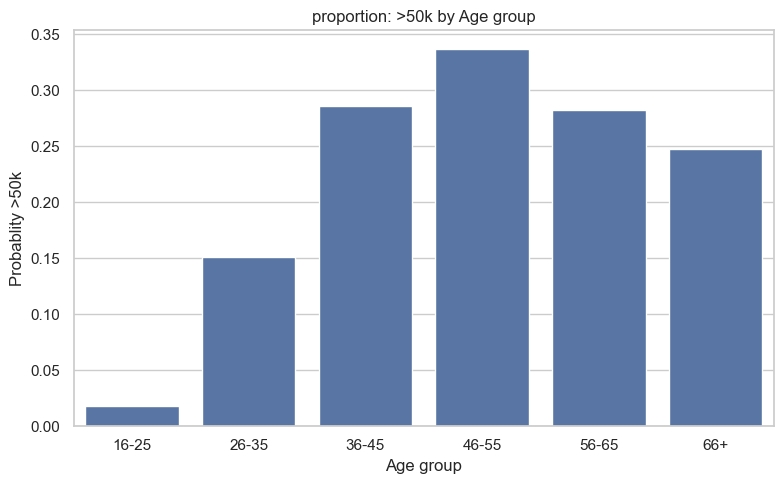


Logistic Regression Accuracy:  0.7579631635969664

Classification Report Logistic regression: 
               precision    recall  f1-score   support

           0       0.94      0.74      0.83      3638
           1       0.46      0.82      0.59       977

    accuracy                           0.76      4615
   macro avg       0.70      0.78      0.71      4615
weighted avg       0.84      0.76      0.78      4615


Logistic Regression Confusion matrix: 
 [[2697  941]
 [ 176  801]]

SVM Classification Score: 0.7882990249187433
RandomForest val accuracy: 0.7989165763813652
KNN val accuracy: 0.7698808234019502
Naive Bayes val accuracy: 0.7973997833152763
Gradient Boosting Metrics
-------------------------
[[3357  281]
 [ 483  494]]
Precision: 0.6374
Recall   : 0.5056
F1 Score : 0.5639

Detailed Classification Report GB:
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      3638
           1       0.64      0.51      0.56       977

 

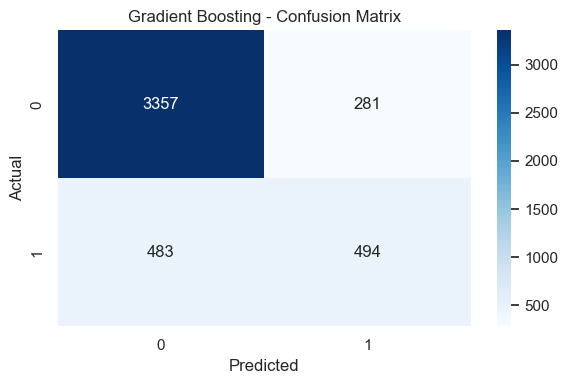

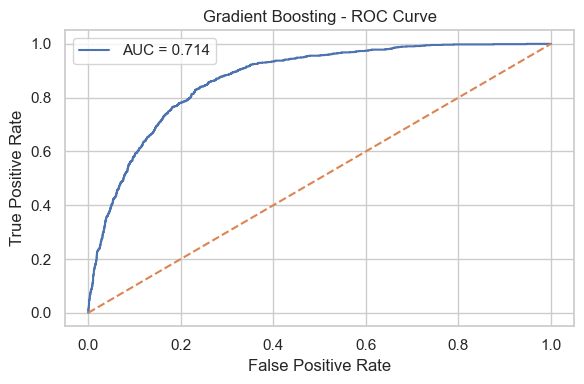

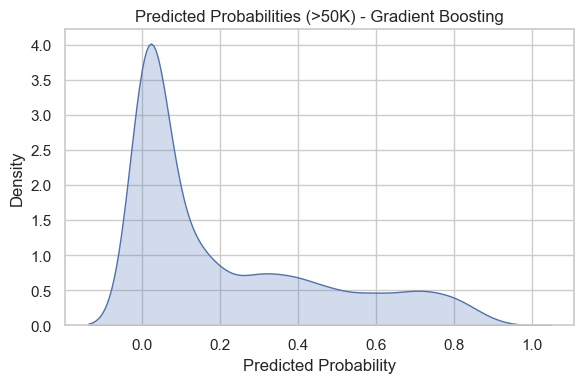


Model comparison:


,Accuracy
Gradient Boosting,0.834453
Random Forest,0.798917
Naive Bayes,0.797400
SVM,0.788299
KNN,0.769881
LogisticRegression,0.757963


Saved Logistic regression pipeline
Saved svm pipeline
Saved random forest pipeline
Saved knn pipeline
Saved naive bayes pipeline
Saved gradient boosting pipeline


In [7]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 1) Paths & Settings
DATA_PATH = Path('data/adult.data') # uploaded dataset
OUTPUT_DIR = Path('output')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

cols = [
   "age","workclass","fnlwgt","education","education-num","marital-status","occupation",
   "relationship","race","sex","capital-gain","capital-loss","hours-per-week",
   "native-country","income"
]

print('Loading dataset...')
df = pd.read_csv(DATA_PATH, names=cols, sep=',', na_values=["?", " ?"], header=None, skipinitialspace=True)
df.head()

print("shape", df.shape)
# df.info()
df.describe(include='all').T
# print(df.head())

# counts = (df == ' ?').sum()

# 1. Remove data with missing values
# Quick info
print('\nMissing values per column:')
print(df.isna().sum())
print(df[df.isna().any(axis=1)])

print('\nDropping rows with missing values...')
df_clean = df.dropna().reset_index(drop=True)

d_value = df_clean.duplicated(keep=False)
df_clean.drop_duplicates(keep='first')

print('After droping missing: \n', df_clean)
print(df.shape)

# num_cols = ["age","fnlwgt","hours-per-week","education-num"]

df_clean['income_bin'] = df_clean['income'].apply(
   lambda x: 1 if str(x).strip() in ([">50K", ">50K."]) else 0
)
# print(cat_cols)
# print(num_cols)
cat_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
# num_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
cat_cols.remove('income') # removing original target

print(cat_cols)
print(num_cols)

# Save intermediate cleaned file
intermediate_path = OUTPUT_DIR / 'adult_clean_initial.csv'
df_clean.to_csv(intermediate_path, index=False)
print('Saved intermediate cleaned csv to', intermediate_path)

# 2. Remove outliers method (IQR)
df_no_outliers = df_clean.copy()

def remove_outliers_iqr(df, col):
   Q1 = df[col].quantile(0.25)
   Q3 = df[col].quantile(0.75)
   IQR = Q3 - Q1
   lower = Q1 - 1.5 * IQR
   upper = Q3 + 1.5 * IQR
   return df[(df[col] >= lower) & (df[col] <= upper)]

for c in num_cols:
   before = df_no_outliers.shape[0]
   df_no_outliers = remove_outliers_iqr(df_no_outliers, c)
   after = df_no_outliers.shape[0]
   print(f"Removed outliers in {c}: {before - after} rows")
   print("Shape after outlier removal: ", df_no_outliers.shape)

# Save cleaned dataset
cleaned_path = OUTPUT_DIR / 'adult_clean.csv'
df_no_outliers.to_csv(cleaned_path, index=False)
print('Saved cleaned dataset to', cleaned_path)


# Prepare data for classification and regression
from sklearn.model_selection import train_test_split

df_model = df_no_outliers.copy()

# print(df_model[num_cols])

X = df_model.drop(columns=['income', 'income_bin'])
y = df_model['income_bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

 

# 3. Establish the importance of the weekly working hours on earning potential
from scipy import stats
sns.set(style='whitegrid')

# box plot
plt.figure(figsize = (8, 6))
sns.boxplot(x='income', y="hours-per-week", data=df_no_outliers)
plt.title('Hours per week by income group: ')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'box_hours_by_income.png')
plt.show()

means = df_no_outliers.groupby('income')['hours-per-week'].mean()
medians = df_no_outliers.groupby('income')['hours-per-week'].median()

# print('Mean hours per weak: \n', means)
# print('Median hours per weak: \n', medians)

high_income = df_no_outliers[df_no_outliers['income_bin'] == 1]['hours-per-week']
low_income = df_no_outliers[df_no_outliers['income_bin'] == 0]['hours-per-week']
# print(high_income)
# print(low_income)
# print(df_no_outliers.head())

tstat, pval = stats.ttest_ind(high_income, low_income, equal_var = False)
print("t-stat:  ", tstat, "p-value: ", pval)

 
#4. find features highly correlated/important for earning potential
import joblib
from sklearn.ensemble import RandomForestClassifier

# Numberic correlation
corr_with_target = X.select_dtypes(include=[np.number]).assign(income=y).corr()['income'].sort_values(ascending=False)
print("Numberic correlation with income: \n", corr_with_target)


# corr_sorted = corr_with_target.sort_values(ascending=False)

plt.figure(figsize=(6, 3))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette="coolwarm", hue=corr_with_target.values, dodge=False, legend=False)
plt.xlim(-1, 1)  # correlation range
plt.xlabel("Correlation with income")
plt.ylabel("Feature")
plt.title("Feature Correlations with Income")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'bar_corr-with_income.png')
plt.show()

# Correlation heatmap (numeric)
numdf = df_model[num_cols + ['income_bin']]
plt.figure(figsize=(8,6))
sns.heatmap(numdf.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Numeric Correlation Matrix')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'corr_numeric.png')
plt.show()

# Histogram: hours_per_week
plt.figure(figsize=(8,4))
sns.histplot(df_model["hours-per-week"], bins=30)
plt.title('Distribution of hours per week')
plt.xlabel('Hours per week')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'hist_hours_per_week.png')
plt.show()

 
# 5. Find the relation between the number of years spent to get the degree and earning potential

# group by education-num
edu_vs_income = df_no_outliers.groupby('education-num')['income_bin'].agg(['count', 'mean']).rename(columns={'mean':'pct_above_50k'})
edu_vs_income = edu_vs_income.reset_index()

plt.figure(figsize=(8, 5))
sns.lineplot(data=edu_vs_income, x='education-num', y='pct_above_50k', marker='o')
plt.title("Proportion earning >50k by education-num (years)")
plt.ylabel("proportion >50k")
plt.xlabel("education-num (years)")
plt.grid(True)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'line_edu_num_pct_above_50k.png')
plt.show()
edu_vs_income.head()

 
# 6. Find the relationship between age and earning potential

# create age bins
df_no_outliers['age_bin'] = pd.cut(df_no_outliers['age'], bins=[16, 25, 35, 45, 55, 65, 90], 
                                  labels=['16-25', '26-35', '36-45', '46-55', '56-65', '66+'])
age_tab = df_no_outliers.groupby('age_bin', observed=True)['income_bin'].agg(['count', 'mean']).rename(columns={'mean':'pct_above_50k'})
age_tab = age_tab.reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=age_tab, x='age_bin', y='pct_above_50k')
plt.title("proportion: >50k by Age group")
plt.ylabel("Probablity >50k")
plt.xlabel("Age group")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'bar_age_prob_above_50k.png')
plt.show()

 

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression

# Preprocessors
numeric_transformer = Pipeline(steps=[
   ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
   ("imputer", SimpleImputer(strategy="most_frequent")),
   ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
   transformers=[
       ("num", numeric_transformer, num_cols),
       ("cat", categorical_transformer, cat_cols)
   ],
   remainder="drop"  # or "passthrough" if you want to keep untouched columns
)

# Final pipeline: preprocessing + model
log_pipe = Pipeline(steps=[
   ("preprocess", preprocessor),
   ("clf", LogisticRegression(max_iter=500, solver="lbfgs", class_weight="balanced"))
])

svm_model = Pipeline(steps=[
   ("preprocess", preprocessor),
   ("clf", SVC(kernel="rbf", C=1.0))
])

rf_model = Pipeline(steps=[
   ("preprocess", preprocessor),
   ("clf", RandomForestClassifier(
       n_estimators=300,
       max_depth=None,
       min_samples_leaf=2,
       class_weight="balanced",
       random_state=42,
       n_jobs=-1
   ))
])

knn_model = Pipeline(steps=[
   ("preprocess", preprocessor),
   ("clf", KNeighborsClassifier(
       n_neighbors=15,
       weights="distance",
       n_jobs=-1
   ))
])

nb_model = Pipeline(steps=[
   ("preprocess", preprocessor),
   ("clf", GaussianNB())
])

gb_model = Pipeline(steps=[
    ('preprocess', preprocessor), 
    ('clf', HistGradientBoostingClassifier())
])
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report, 
confusion_matrix, mean_squared_error, roc_curve, roc_auc_score)

all_results = {}
# LogisticRegression(max_iter=500)
log_pipe.fit(X_train, y_train)
y_pred_log = log_pipe.predict(X_test)
y_pred_log_prob = log_pipe.predict_proba(X_test)[:,1]

log_acc =  accuracy_score(y_test, y_pred_log)
print('\nLogistic Regression Accuracy: ', log_acc)
print('\nClassification Report Logistic regression: \n', classification_report(y_test, y_pred_log))
print('\nLogistic Regression Confusion matrix: \n', confusion_matrix(y_test, y_pred_log))
# print("Linear prediction probablity : ", y_pred_log_prob)
all_results.update({'LogisticRegression': log_acc})

svm_model.fit(X_train, y_train)
svm_acc =  svm_model.score(X_test, y_test)
print("\nSVM Classification Score:", svm_acc)
all_results.update({'SVM': svm_acc})


rf_model.fit(X_train, y_train)
rf_acc =  rf_model.score(X_test, y_test)
print("RandomForest val accuracy:", rf_acc)
all_results.update({'Random Forest': rf_acc})

knn_model.fit(X_train, y_train)
knn_acc =  knn_model.score(X_test, y_test)
print("KNN val accuracy:", knn_acc)
all_results.update({'KNN': knn_acc})

nb_model.fit(X_train, y_train)
nb_acc =  nb_model.score(X_test, y_test)
print("Naive Bayes val accuracy:", nb_acc)
all_results.update({'Naive Bayes': nb_acc})

gb_model.fit(X_train, y_train)
gb_acc =  gb_model.score(X_test, y_test)
y_pred_gb = gb_model.predict(X_test)
y_pred_prob = gb_model.predict_proba(X_test)[:,1]

# Metrics
precision = precision_score(y_test, y_pred_gb)
recall = recall_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)

print("Gradient Boosting Metrics")
print("-------------------------")
print(confusion_matrix(y_test, y_pred_gb))
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

print("\nDetailed Classification Report GB:")
print(classification_report(y_test, y_pred_gb))
print("Gradient Boosting val accuracy:", gb_acc)
all_results.update({'Gradient Boosting': gb_acc})

# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Gradient Boosting - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'gb_confusion_matrix.png')
plt.show()

# ROC & AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_gb)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting - ROC Curve')
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'gb_roc_auc.png')
plt.show()

# Predicted probability distribution (test)
plt.figure(figsize=(6,4))
sns.kdeplot(y_pred_prob, fill=True)
plt.title('Predicted Probabilities (>50K) - Gradient Boosting')
plt.xlabel('Predicted Probability')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'gb_pred_prob_dist.png')
plt.show()

# Compare models
res_df = pd.DataFrame.from_dict(all_results, orient='index', columns=['Accuracy']).sort_values('Accuracy', ascending=False)
print('\nModel comparison:')
display(res_df)
res_df.to_csv(OUTPUT_DIR / 'model_comparison.csv')

joblib.dump(log_pipe, OUTPUT_DIR / 'logistic_pipeline.joblib')
print('Saved Logistic regression pipeline')

joblib.dump(svm_model, OUTPUT_DIR /  'svm_pipeline.joblib')
print('Saved svm pipeline')

joblib.dump(rf_model, OUTPUT_DIR /  'random-forest_pipeline.joblib')
print('Saved random forest pipeline')

joblib.dump(knn_model, OUTPUT_DIR /  'knn_pipeline.joblib')
print('Saved knn pipeline')

joblib.dump(nb_model, OUTPUT_DIR /  'naive-bayes_pipeline.joblib')
print('Saved naive bayes pipeline')

joblib.dump(gb_model, OUTPUT_DIR /  'gb_pipeline.joblib')
print('Saved gradient boosting pipeline')